In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [3]:
loss_thresh = 25000
label = "ES_rowdy"


x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
fea_data = scipy.io.loadmat('./../ES_FEA.mat')

xy = np.array(fea_data['xy'])
u_true = np.array(fea_data['u'])

xy_test_tensor = torch.from_numpy(xy).float().to(device)
u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    N_t = int(N_T/4)
    
    x_BC1 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC1 = np.zeros((N_t,1))
    u_BC1 = 0*np.ones((N_t,1))
    
    x_BC2 = np.ones((N_t,1))
    y_BC2 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC2 = 1000*np.ones((N_t,1))
    
    x_BC3 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC3 = np.ones((N_t,1)) 
    u_BC3 = 0*np.ones((N_t,1))
    
    x_BC4 = np.zeros((N_t,1))
    y_BC4 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC4 = 1000*np.ones((N_t,1))
    
    XY_corners = np.array([[0,0],[1,0],[0,1],[1,1]]).reshape(-1,2)
    U_corners = 1000*np.ones((4,1))
    
    XY_1 = np.hstack((x_BC1,y_BC1))
    XY_2 = np.hstack((x_BC2,y_BC2))
    XY_3 = np.hstack((x_BC3,y_BC3))
    XY_4 = np.hstack((x_BC4,y_BC4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4,XY_corners)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4,U_corners))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
                
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
     
    'callable for optimizer'  
    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
     
        
        return test_mse, test_re 

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(PINN.alpha.cpu().detach().numpy())
    omega_val.append(PINN.omega.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [9]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        

            
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))
    

In [10]:
max_reps = 10
max_iter = 200 #200



train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
omega_full = []
elapsed_time= np.zeros((max_reps,1))

n_val = 5.0
rowdy_terms = 6

N_T = 5000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    alpha_val = []    
    omega_val = []

    torch.manual_seed(reps*36)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers,n_val,rowdy_terms)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())

    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')





    nan_flag = train_model(max_iter,reps)


    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    alpha_full.append(alpha_val)
    omega_full.append(omega_val)


    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time,"alpha": alpha_full,"omega": omega_full,  "label": label}
savemat(label+'.mat', mdic)

ES_rowdy
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 495952.53 Test MSE 322159.50877912925 Test RE 0.993050922178195
1 Train Loss 488412.06 Test MSE 314665.4660189879 Test RE 0.9814328335438246
2 Train Loss 470641.56 Test MSE 296825.463465602 Test RE 0.9532056746527949
3 Train Loss 441350.97 Test MSE 266399.7326689107 Test RE 0

96 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
97 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
98 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
99 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
100 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
101 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
102 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
103 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
104 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
105 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
106 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
107 Train Loss 97204.445 Test MSE 18992.98387042245 Test RE 0.2411196705362008
108 Train Loss 97204.445 Test MSE 18992.98387042245 Test

0 Train Loss 490978.5 Test MSE 317076.5626178919 Test RE 0.9851857298067924
1 Train Loss 463791.7 Test MSE 288802.5641318613 Test RE 0.9402353260254865
2 Train Loss 437196.22 Test MSE 262801.24605726515 Test RE 0.8969118292030378
3 Train Loss 381122.2 Test MSE 206984.15740436327 Test RE 0.7959844703321247
4 Train Loss 263375.06 Test MSE 87846.51968681093 Test RE 0.5185591740653198
5 Train Loss 249991.84 Test MSE 75076.70464541108 Test RE 0.4793896382392645
6 Train Loss 249952.89 Test MSE 75059.48760694882 Test RE 0.4793346668394913
7 Train Loss 249748.22 Test MSE 74968.94191511789 Test RE 0.4790454643190384
8 Train Loss 248657.5 Test MSE 74506.0710962471 Test RE 0.47756432105878727
9 Train Loss 246891.6 Test MSE 73462.61523974869 Test RE 0.47420839088843425
10 Train Loss 246395.16 Test MSE 73105.85150807186 Test RE 0.4730555170310807
11 Train Loss 245516.48 Test MSE 72731.65518713757 Test RE 0.4718432834816632
12 Train Loss 244858.61 Test MSE 72332.75956770855 Test RE 0.470547595959537

105 Train Loss 72556.516 Test MSE 12728.546972119371 Test RE 0.19739014071065447
106 Train Loss 71772.93 Test MSE 12794.485228351108 Test RE 0.19790075472462093
107 Train Loss 71475.266 Test MSE 12865.48783778017 Test RE 0.1984491171282741
108 Train Loss 70815.95 Test MSE 13135.129969813775 Test RE 0.20051793758270367
109 Train Loss 70608.58 Test MSE 13254.488052238448 Test RE 0.20142692408730734
110 Train Loss 70406.64 Test MSE 13403.262386314187 Test RE 0.20255422277368623
111 Train Loss 69772.875 Test MSE 13913.926284480734 Test RE 0.20637680796149332
112 Train Loss 68507.05 Test MSE 14064.95495267001 Test RE 0.20749384312882688
113 Train Loss 67853.7 Test MSE 13564.062412547766 Test RE 0.20376562999025746
114 Train Loss 67355.09 Test MSE 13449.804230951751 Test RE 0.20290559534320587
115 Train Loss 66970.086 Test MSE 13552.704432400371 Test RE 0.2036802997034642
116 Train Loss 66532.93 Test MSE 13158.784623846675 Test RE 0.20069840967964617
117 Train Loss 65817.96 Test MSE 13027.86

0 Train Loss 498875.25 Test MSE 324723.9189197389 Test RE 0.9969954622298202
1 Train Loss 458147.6 Test MSE 284247.7870835425 Test RE 0.9327915172886199
2 Train Loss 414288.47 Test MSE 240335.46186257538 Test RE 0.8577188803890914
3 Train Loss 350127.38 Test MSE 175991.95588752316 Test RE 0.7339769995764227
4 Train Loss 278293.47 Test MSE 102721.50196841024 Test RE 0.5607466946646077
5 Train Loss 258370.56 Test MSE 83664.78650773478 Test RE 0.5060662740468972
6 Train Loss 249739.27 Test MSE 75016.69314381582 Test RE 0.47919800327422196
7 Train Loss 248623.94 Test MSE 74309.27060469381 Test RE 0.47693318431500054
8 Train Loss 246361.66 Test MSE 73705.99646058663 Test RE 0.47499326618692694
9 Train Loss 243732.84 Test MSE 72463.07452792299 Test RE 0.47097127534184174
10 Train Loss 239416.53 Test MSE 70625.61378193818 Test RE 0.4649616774314988
11 Train Loss 232782.52 Test MSE 68386.95106502643 Test RE 0.4575332520976019
12 Train Loss 230659.48 Test MSE 68129.99907977105 Test RE 0.4566728

105 Train Loss 135883.88 Test MSE 35179.18618015677 Test RE 0.328154932157946
106 Train Loss 135260.25 Test MSE 34705.86504604346 Test RE 0.3259398630169803
107 Train Loss 134607.22 Test MSE 34035.737772059605 Test RE 0.32277777706980976
108 Train Loss 133733.84 Test MSE 33685.27523965702 Test RE 0.32111167206198465
109 Train Loss 133301.47 Test MSE 34008.86266438281 Test RE 0.32265031691802126
110 Train Loss 133028.22 Test MSE 33905.876376313085 Test RE 0.32216141858566566
111 Train Loss 132191.12 Test MSE 34044.79863054571 Test RE 0.3228207385175566
112 Train Loss 131797.97 Test MSE 34058.0094423168 Test RE 0.3228833664451863
113 Train Loss 131587.1 Test MSE 33638.5968680988 Test RE 0.32088910944279003
114 Train Loss 131350.39 Test MSE 33167.03082349365 Test RE 0.31863196292934015
115 Train Loss 131117.78 Test MSE 32784.66007755889 Test RE 0.3167899420027716
116 Train Loss 130779.664 Test MSE 32501.11784401773 Test RE 0.3154170684701775
117 Train Loss 130328.164 Test MSE 32395.257845

0 Train Loss 492383.16 Test MSE 318549.008983012 Test RE 0.9874705926712224
1 Train Loss 470446.03 Test MSE 296502.46144175075 Test RE 0.9526868998079226
2 Train Loss 405959.3 Test MSE 230580.61910719736 Test RE 0.8401318362108752
3 Train Loss 332486.62 Test MSE 157615.11892901533 Test RE 0.6946003196818793
4 Train Loss 266613.22 Test MSE 91810.94470676032 Test RE 0.5301310843589702
5 Train Loss 249932.47 Test MSE 75044.77685988694 Test RE 0.4792876926541064
6 Train Loss 249783.62 Test MSE 74968.32824813147 Test RE 0.47904350367386633
7 Train Loss 249523.06 Test MSE 74850.28213107392 Test RE 0.478666200983754
8 Train Loss 249166.11 Test MSE 74590.72604795298 Test RE 0.47783555202478833
9 Train Loss 248765.88 Test MSE 74303.81166185768 Test RE 0.47691566564750293
10 Train Loss 247708.69 Test MSE 73857.37852402992 Test RE 0.4754808016729985
11 Train Loss 244794.39 Test MSE 72742.36018003424 Test RE 0.4718780062797227
12 Train Loss 243183.16 Test MSE 72056.2101439841 Test RE 0.46964721356

105 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
106 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
107 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
108 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
109 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
110 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
111 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
112 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
113 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
114 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
115 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
116 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.305560960484767
117 Train Loss 136727.77 Test MSE 30501.67219177441 Test RE 0.30

1 Train Loss 465387.4 Test MSE 291307.82944534946 Test RE 0.9443046330549321
2 Train Loss 394153.6 Test MSE 216729.65033124725 Test RE 0.8145077238239398
3 Train Loss 283814.5 Test MSE 106724.43446739455 Test RE 0.5715680877576018
4 Train Loss 250030.2 Test MSE 75095.68906371383 Test RE 0.4794502453091054
5 Train Loss 249996.52 Test MSE 75079.7703579739 Test RE 0.4793994259346649
6 Train Loss 249926.69 Test MSE 75024.44484297145 Test RE 0.47922276111575357
7 Train Loss 249545.5 Test MSE 74816.93398781106 Test RE 0.47855955871768724
8 Train Loss 247723.61 Test MSE 73611.65852790952 Test RE 0.47468919167200924
9 Train Loss 245738.62 Test MSE 72540.05878631755 Test RE 0.4712213872078566
10 Train Loss 241554.8 Test MSE 71167.2195473184 Test RE 0.46674109541107595
11 Train Loss 235523.08 Test MSE 68729.54939387437 Test RE 0.4586778732382668
12 Train Loss 229909.38 Test MSE 67558.17270847753 Test RE 0.45475238876656304
13 Train Loss 221860.39 Test MSE 64028.94574477 Test RE 0.442714980088808

106 Train Loss 43776.203 Test MSE 6549.851553733282 Test RE 0.14159625609614854
107 Train Loss 43709.22 Test MSE 6522.038817715992 Test RE 0.1412953050862438
108 Train Loss 43641.914 Test MSE 6594.234645040525 Test RE 0.14207518826815874
109 Train Loss 43588.023 Test MSE 6559.694656157447 Test RE 0.14170261142370957
110 Train Loss 43547.85 Test MSE 6539.230263780215 Test RE 0.14148140272329843
111 Train Loss 43512.0 Test MSE 6528.159795831091 Test RE 0.14136159284295519
112 Train Loss 43487.73 Test MSE 6525.662424307004 Test RE 0.1413345510580166
113 Train Loss 43453.707 Test MSE 6530.145235137967 Test RE 0.14138308768491373
114 Train Loss 43420.844 Test MSE 6473.385185082327 Test RE 0.1407672954486582
115 Train Loss 43371.465 Test MSE 6488.983337646614 Test RE 0.14093678858039757
116 Train Loss 43310.02 Test MSE 6481.883502390393 Test RE 0.14085966541763187
117 Train Loss 43271.445 Test MSE 6456.300356429543 Test RE 0.1405814132567575
118 Train Loss 43233.086 Test MSE 6482.21557898886

0 Train Loss 488325.2 Test MSE 314742.44238322077 Test RE 0.9815528697723424
1 Train Loss 452123.97 Test MSE 278283.7132911679 Test RE 0.9229537457835781
2 Train Loss 402085.34 Test MSE 226532.7950734775 Test RE 0.8327249624526493
3 Train Loss 350027.62 Test MSE 175265.21249297968 Test RE 0.7324599849380754
4 Train Loss 290530.28 Test MSE 114046.02834306512 Test RE 0.5908484827333447
5 Train Loss 256685.17 Test MSE 81839.43006558888 Test RE 0.5005152795184216
6 Train Loss 249661.94 Test MSE 74904.95118799424 Test RE 0.47884097289246813
7 Train Loss 249450.08 Test MSE 74764.70450698608 Test RE 0.4783924890470528
8 Train Loss 248516.05 Test MSE 74034.74685942505 Test RE 0.47605139237072064
9 Train Loss 244166.67 Test MSE 72335.96269986783 Test RE 0.47055801454069074
10 Train Loss 241020.67 Test MSE 70891.23923812422 Test RE 0.46583522557953794
11 Train Loss 239069.53 Test MSE 70861.2036845121 Test RE 0.4657365314294114
12 Train Loss 237847.5 Test MSE 70930.03818162804 Test RE 0.465962684

105 Train Loss 53770.527 Test MSE 7308.03524913061 Test RE 0.1495671983189831
106 Train Loss 53611.684 Test MSE 7065.9971015959745 Test RE 0.14706955194503712
107 Train Loss 53264.586 Test MSE 6853.537665399222 Test RE 0.14484164341130848
108 Train Loss 53208.938 Test MSE 6856.035691037763 Test RE 0.14486803745719648
109 Train Loss 53194.21 Test MSE 6874.207399779326 Test RE 0.14505989452076673
110 Train Loss 53170.363 Test MSE 6809.735602937595 Test RE 0.14437804836694754
111 Train Loss 53076.23 Test MSE 6779.760169466087 Test RE 0.14405993266300185
112 Train Loss 52983.445 Test MSE 6781.323884664397 Test RE 0.14407654502927933
113 Train Loss 52791.5 Test MSE 6922.272742608949 Test RE 0.14556614983735888
114 Train Loss 52393.996 Test MSE 6716.472972438987 Test RE 0.1433859762454657
115 Train Loss 52162.152 Test MSE 6707.40845175183 Test RE 0.1432891870545332
116 Train Loss 52108.773 Test MSE 6718.954911066696 Test RE 0.14341246651230694
117 Train Loss 52059.484 Test MSE 6689.636855001

0 Train Loss 487600.7 Test MSE 313724.9126585284 Test RE 0.9799649559489938
1 Train Loss 475391.2 Test MSE 300651.95311736705 Test RE 0.9593300678670478
2 Train Loss 449963.28 Test MSE 276127.21712851746 Test RE 0.9193706809787938
3 Train Loss 429179.6 Test MSE 255278.41688865202 Test RE 0.8839813262228708
4 Train Loss 413824.34 Test MSE 239477.8958163848 Test RE 0.8561872547495509
5 Train Loss 400042.6 Test MSE 226126.97816993608 Test RE 0.8319787452276578
6 Train Loss 392988.88 Test MSE 218965.54536115826 Test RE 0.8186983845184265
7 Train Loss 381574.12 Test MSE 207227.99637517537 Test RE 0.7964531895502426
8 Train Loss 363105.78 Test MSE 188212.9785503951 Test RE 0.7590332932957916
9 Train Loss 349254.47 Test MSE 174985.11785854542 Test RE 0.7318744718715596
10 Train Loss 340492.22 Test MSE 166021.42345210395 Test RE 0.7128827539837145
11 Train Loss 331942.38 Test MSE 157088.857652386 Test RE 0.6934397492669369
12 Train Loss 327971.66 Test MSE 153532.70733939696 Test RE 0.685545833

105 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
106 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
107 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
108 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
109 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
110 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
111 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
112 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
113 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
114 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
115 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
116 Train Loss 216675.69 Test MSE 62232.430223815005 Test RE 0.4364599738097604
117 Train Loss 216675.69 Test MSE 62232.

0 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
1 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
2 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
3 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
4 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
5 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
6 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
7 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
8 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
9 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
10 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
11 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
12 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.

104 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
105 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
106 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
107 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
108 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
109 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
110 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
111 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
112 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
113 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
114 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
115 Train Loss 499576.22 Test MSE 325793.11751090613 Test RE 0.9986354863339163
116 Train Loss 499576.22 Test MSE 325793

0 Train Loss 487012.7 Test MSE 312962.6688413985 Test RE 0.9787737427681799
1 Train Loss 444202.56 Test MSE 267468.5536256148 Test RE 0.9048412821097866
2 Train Loss 397432.84 Test MSE 223423.7870883002 Test RE 0.8269909297079684
3 Train Loss 319764.28 Test MSE 140445.8498310731 Test RE 0.6556778263955924
4 Train Loss 262298.56 Test MSE 86867.2576829518 Test RE 0.5156607756963276
5 Train Loss 250087.67 Test MSE 75102.80671057783 Test RE 0.4794729661651219
6 Train Loss 249657.5 Test MSE 74807.89411505147 Test RE 0.47853064649171473
7 Train Loss 248985.64 Test MSE 73940.97098057435 Test RE 0.4757498023403106
8 Train Loss 246759.8 Test MSE 73220.2935924359 Test RE 0.47342563985805486
9 Train Loss 240660.64 Test MSE 70630.94663885118 Test RE 0.4649792314544468
10 Train Loss 234888.31 Test MSE 69783.60960845258 Test RE 0.4621817118321614
11 Train Loss 227899.44 Test MSE 66489.16412584674 Test RE 0.45114014879882364
12 Train Loss 218035.61 Test MSE 63609.35000875397 Test RE 0.441261991516921

105 Train Loss 43210.094 Test MSE 6320.938115031616 Test RE 0.13909989784438948
106 Train Loss 43107.836 Test MSE 6366.792425514433 Test RE 0.13960352593677153
107 Train Loss 43025.85 Test MSE 6361.098881356493 Test RE 0.1395410913100948
108 Train Loss 43006.75 Test MSE 6360.649904791766 Test RE 0.1395361667061452
109 Train Loss 43003.2 Test MSE 6374.8113360186735 Test RE 0.13969141288500758
110 Train Loss 42989.926 Test MSE 6363.758216214027 Test RE 0.13957025668850653
111 Train Loss 42986.164 Test MSE 6365.730855878765 Test RE 0.13959188702723316
112 Train Loss 42983.457 Test MSE 6367.998988261253 Test RE 0.13961675335357632
113 Train Loss 42980.04 Test MSE 6368.4111124449355 Test RE 0.1396212711392796
114 Train Loss 42976.6 Test MSE 6364.7014530026 Test RE 0.13958059986296223
115 Train Loss 42960.7 Test MSE 6371.167857831058 Test RE 0.13965148736146699
116 Train Loss 42959.0 Test MSE 6374.762406373125 Test RE 0.13969087678565703
117 Train Loss 42958.566 Test MSE 6375.958201971496 Te

0 Train Loss 496205.12 Test MSE 321646.15263491723 Test RE 0.9922594011682532
1 Train Loss 485962.56 Test MSE 312099.59946849756 Test RE 0.9774232097354066
2 Train Loss 469119.25 Test MSE 294774.235369287 Test RE 0.9499063756097199
3 Train Loss 441450.38 Test MSE 266872.0053894196 Test RE 0.9038316628948541
4 Train Loss 404196.38 Test MSE 230221.03165640365 Test RE 0.8394764933225695
5 Train Loss 362641.5 Test MSE 187715.04226500512 Test RE 0.75802857903812
6 Train Loss 269059.9 Test MSE 94415.1956552937 Test RE 0.5375971906946615
7 Train Loss 250276.62 Test MSE 75250.13175200886 Test RE 0.47994301362260683
8 Train Loss 249555.72 Test MSE 74782.3427098742 Test RE 0.4784489159816075
9 Train Loss 248492.73 Test MSE 74308.00808563904 Test RE 0.4769291327357982
10 Train Loss 246294.34 Test MSE 73124.57421854032 Test RE 0.47311608888887174
11 Train Loss 244218.83 Test MSE 72036.17839750052 Test RE 0.46958192767806145
12 Train Loss 239926.97 Test MSE 69982.1926636763 Test RE 0.46283885936358

105 Train Loss 52462.418 Test MSE 6800.712698377429 Test RE 0.14428236615284934
106 Train Loss 52253.24 Test MSE 6774.644663569516 Test RE 0.14400557391880972
107 Train Loss 52112.625 Test MSE 6716.634407480531 Test RE 0.14338769942532786
108 Train Loss 52015.926 Test MSE 6714.217620630126 Test RE 0.14336190014372768
109 Train Loss 51819.28 Test MSE 6723.6506680241455 Test RE 0.14346257195841952
110 Train Loss 51680.26 Test MSE 6705.78500742478 Test RE 0.14327184532731915
111 Train Loss 51510.008 Test MSE 6779.363254226914 Test RE 0.14405571566873468
112 Train Loss 51387.277 Test MSE 6709.732623339237 Test RE 0.143314010338775
113 Train Loss 51115.137 Test MSE 6749.898794214346 Test RE 0.14374232740128035
114 Train Loss 51006.043 Test MSE 6750.46229642789 Test RE 0.1437483273008119
115 Train Loss 50760.684 Test MSE 6641.320977290236 Test RE 0.14258153207809854
116 Train Loss 50598.13 Test MSE 6672.279454753015 Test RE 0.14291346717307726
117 Train Loss 50511.484 Test MSE 6629.580868605

In [11]:
u_pred = PINN.test()

ValueError: cannot reshape array of size 1541 into shape (500,500)

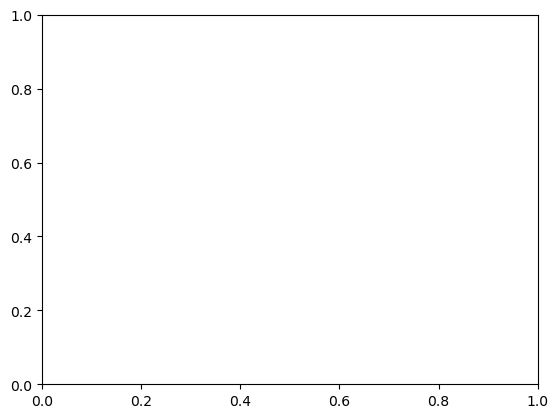

In [12]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(np.flipud(np.transpose(u_pred.reshape(500,500)))),vmin = 0,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [ ]:
import scipy.io as sio
import numpy as np

for tune_reps in range(75):
    label = "MW_rowdy_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re_loss"])
    print(tune_reps," ",np.mean(re[:,-1]))

In [ ]:
lrnr_tune[31]